# **Extract, Load and Transform Data**

## Objectives

* Extract and prepare the Kaggle synthetic credit card transactions dataset for analysis and modelling. Specifically:
    - Validate dataset structure.
    - Perform exploratory quality checks (missing values, duplicates, ranges).
    - Clean and standardise data.
    - Engineer features to improve interpretability and model performance.

## Inputs

* Sampled Kaggle Credit Card Fraud Dataset data/raw/card_transdata_sample_100k.csv (this was produced from full dataset downloaded from https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data/code).

**What this notebook does**
- Load and inspect the sampled dataset.
- Conduct data quality checks (missing values, duplicates, range validation).
- Clean and standardise variables, ensuring binary features are integer-encoded.
- Explore continuous feature distributions and detect skew/outliers.
- Perform feature engineering:
    - Log-transform skewed continuous variables.
    - Bin continuous variables into categories.
    - Create interaction and cross-features capturing potential fraud risk patterns.
- Export a cleaned, feature-enhanced dataset for use in modelling and EDA notebooks.

## Outputs
- * Processed file TBC

---

# Change working directory

I need to change the working directory from the current folder to its parent folder (required because the notebook is being run from inside the jupyter notebooks subfolder). In the code below, I change the working directory from its current folder to its parent folder.  
* I access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\DA_Capstone\\Credit-Card-Fraud-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\DA_Capstone\\Credit-Card-Fraud-Analysis'

---
# Section 1: Data Load (100k Sample)
**About the Dataset:**

This notebook works with a pre-created stratified sample of 100,000 rows from a larger synthetic credit card fraud dataset (originally 1M rows). The sample preserves the fraud class balance (8.74% fraud rate) and was created using stratified sampling.

**Sample Creation Details:**
- Original dataset: 1,000,000 rows, 87,403 fraud cases (8.74%)
- Sample dataset: 100,000 rows, 8,740 fraud cases (8.74%)
- Method: Stratified sampling via sklearn.model_selection.train_test_split
- Random seed: 42 (for reproducibility)
- Validation: data/raw/sample_log.json for full metadata and checksums

**In this section:**
- Load the 100k stratified sample from data/raw/card_transdata_sample_100k.csv
- Conduct basic shape and structure checks
- Verify data loaded correctly before proceeding to cleaning and feature engineering

Section 1 content

In [ ]:
# Load libraries and the 100k stratified sample dataset

# Core file handling libraries
from pathlib import Path # load the pathlib library
import json # for reading sample metadat

# Data manipulation and analysis libraries
import numpy as np # load the numpy library
import pandas as pd # load the pandas library

# Data visualisation libraries
import matplotlib.pyplot as plt # load the matplotlib library
import seaborn as sns # load the seaborn library


# load the 100k stratified sample dataset
df = pd.read_csv('data/raw/card_transdata_sample_100k.csv') # load the dataset

print(df.head()) # display the first 5 rows of the dataframe (use print as multiple outputs are not supported in script, single output no print needed)

print(df.shape) # display the shape of the dataframe

# Display fraud rate and counts clearly
fraud_count = int(df['fraud'].sum()) # count the number of fraud cases
fraud_rate = df['fraud'].mean() # calculate the fraud rate
total_rows = df.shape[0] # get the total number of transactions
print(f"Fraud rate: {fraud_rate:.2%} ({fraud_count} fraud cases out of {total_rows} total transactions)") # display fraud rate and counts clearly

   distance_from_home  distance_from_last_transaction  \
0           19.179396                        0.178758   
1           47.192898                        1.224832   
2           54.389043                        5.290910   
3            3.129745                        0.607212   
4            0.925275                        2.238057   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        2.979353              1.0        0.0   
1                        0.293538              1.0        1.0   
2                        4.492304              1.0        1.0   
3                        0.357527              1.0        0.0   
4                        0.684942              0.0        0.0   

   used_pin_number  online_order  fraud  
0              0.0           1.0    0.0  
1              0.0           1.0    0.0  
2              0.0           0.0    0.0  
3              0.0           1.0    0.0  
4              0.0           0.0    0.0  
(100000, 8)
Fr

---

# Section 2 Data Structure and Quality Check

Basic data and structure information checks conduted in code cells below for the 100k stratified sample:
- Checked dataframe shape Shape
- Checked Dtypes
- Checked Missing values
- Checked for Duplicates

**Continuous Variables** (high cardinality - as expected for continuous features):
- distance_from_home
- distance_from_last_transaction
- ratio_to_median_purchase_price 

**Binary Variables** (2 unique values - encoded as 0/1 floats):
- repeat_retailer
- used_chip
- used_pin_number
- online_order
- fraud (target variable)

**Data Quality:**
- Dataframe is 100,000 rows by 8 columns
- No missing values detected
- No duplicate rows
- Binary features stored as float64 (will convert to int for efficiency)
- Continuous features need distribution and outlier analysis

Section 2 content

In [5]:
#  Basic structure of the dataframe and quality check

print("Dataset shape:") # Print "Dataset shape" before next print output for clarity
print(df.shape) # display the shape of the dataframe

print("\nColumn information:") # write "column information" before next print output for clarity

# Check data types, non-null counts and missing values and create summary table
summary = (
    pd.DataFrame({
    'Data Type': df.dtypes, # data types
    'Non-Null Count': df.notnull().sum(), # non-null counts
    'Missing Values': df.isnull().sum(),
   "missing_pct": (df.isna().mean()*100).round(3),  # percent missing NaN values per column 
    'Unique Values': df.nunique() # unique values
})
.sort_values(by='Missing Values', ascending=False) # sort by missing values
)

summary  # display the summary table

Dataset shape:
(100000, 8)

Column information:


,Data Type,Non-Null Count,Missing Values,missing_pct,Unique Values
distance_from_home,float64,100000,0,0.0,100000
distance_from_last_transaction,float64,100000,0,0.0,100000
ratio_to_median_purchase_price,float64,100000,0,0.0,100000
repeat_retailer,float64,100000,0,0.0,2
used_chip,float64,100000,0,0.0,2
used_pin_number,float64,100000,0,0.0,2
online_order,float64,100000,0,0.0,2
fraud,float64,100000,0,0.0,2


**Duplicate Check:**

Verify there are no duplicate rows in the sample (none found).

In [6]:
 # check for duplicate rows
duplicate_rows = df.duplicated().sum() # count duplicate rows
print(f"\nNumber of duplicate rows: {duplicate_rows}") # adds text to the output stating number of duplicate rows for clarity


Number of duplicate rows: 0


---
# Section 3: Range Validation:
Before analysis, key continuous variables are checked below to ensure the values are sensible and within expected limits. This step helps confirm there are no invalid or extreme values (such as negative distances or unrealistic ratios) that could distort analysis results.

Results
- The continuous variables show sensible value ranges with no negative or unrealistic values.
    - distance_from_home spans roughly 0 to 5,798, consistent with local to long-distance transactions.
    - ratio_to_median_purchase_price ranges from about 0.007 to 266.7, indicating occasional high-value purchases but no invalid entries.

These results confirm that the dataset contains realistic transaction values suitable for further analysis.


In [7]:
# Validate ranges are sensible for continuous variables
print("\nValue Range Validation (Continuous Variables):") # adds text to the output before the range validation for clarity
print("-" * 50) # --- separator line for clarity

cont_cols = ["distance_from_home", 
             "distance_from_last_transaction", 
             "ratio_to_median_purchase_price"] # list of continuous variable columns

for col in cont_cols:
    min_val = df[col].min() # calculate minimum value
    max_val = df[col].max() # calculate maximum value
    print(f"{col:35s}: min={min_val:8.3f}, max={max_val:8.3f}") # formatted print for clarity

# Check for any negative values (should be none)
negative_counts = (df[cont_cols] < 0).sum() # count negative values in continuous variables
print("\nNegative Value Counts (Continuous Variables):") # adds text to the output before the
if negative_counts.sum() > 0: # if there are any negative values
    print(negative_counts[negative_counts > 0]) # display counts of negative values
else:
    print("\n✓ All continuous variables have valid non-negative values") # confirmation message if no negative values


Value Range Validation (Continuous Variables):
--------------------------------------------------
distance_from_home                 : min=   0.025, max=5797.973
distance_from_last_transaction     : min=   0.000, max=4968.315
ratio_to_median_purchase_price     : min=   0.007, max= 266.690

Negative Value Counts (Continuous Variables):

✓ All continuous variables have valid non-negative values


---
# Section 4: Descriptive Stats Review for all Variables 
**Aim**

To get an initial sense of the dataset by reviewing averages, middle values, variation, and any obvious extremes before conducting more detailed plots.

**Approach**

df.describe() was used to generate summary statistics for the numeric variables. Adding include="all" includes non-numeric (categorical and object) columns in the summary, providing a more complete overview of the dataset. This summary displays key statistics such as the mean (average), median (middle point), standard deviation (spread of values), and percentiles (positions within the distribution).

These checks are important because they highlight whether the data is balanced, skewed, or contains unusual values. For example:
- distance_from_home has a mean of 26.68 but a median of 9.94, suggesting the distribution is right-skewed, with a few very large distances pulling the mean upwards.
- Binary features such as chip, PIN, and repeat_retailer contain only 0s and 1s as expected (though currently stored as floats).

**Key Insights from Results**
- Continuous features show large ranges and strong skewness, which will require careful treatment (e.g., log transforms or binning) in later stages.
- Binary features appear consistent and clean, confirming correct encoding and no data quality issues.

In [8]:
# Summary Stats for all variables
df.describe(include='all')# display summary statistics for all variables in the dataframe


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,26.681624,5.048395,1.832806,0.880780,0.34857,0.101290,0.651250,0.087400
std,67.723706,28.179679,2.883186,0.324049,0.47652,0.301714,0.476577,0.282422
min,0.024602,0.000434,0.007427,0.000000,0.00000,0.000000,0.000000,0.000000
25%,3.875510,0.293744,0.476066,1.000000,0.00000,0.000000,0.000000,0.000000
50%,9.942868,0.997630,1.002759,1.000000,0.00000,0.000000,1.000000,0.000000
75%,25.717717,3.358880,2.102391,1.000000,1.00000,0.000000,1.000000,0.000000
max,5797.972589,4968.315477,266.689692,1.000000,1.00000,1.000000,1.000000,1.000000


---

# Section 5: Distribution and Outlier Checks


**Aim:**
- To examine the continuous features to understand their distribution, scale, and the presence of extreme values. This will help decide whether transformations (such as log scaling) or outlier handling is needed later.

**Approach:**
- Plot histograms to view the shape and skew of each variable.
- Use boxplots to spot potential outliers.
- Apply the IQR (interquartile range) method to count possible outlier values numerically.

**Visualisation Libraries used:**
- Matplotlib was used for histograms as it is lightweight control for simple distribution plots. It’s ideal for quickly visualising multiple histograms side-by-side with minimal formatting.
- Matplotlib was used for boxplots to visualise the spread and potential outliers in continuous variables. It provides clear, simple plots that show medians, quartiles, and extremes, helping to identify skewness and extreme values in the dataset. Because this dataset has a large spread, the boxes appear compressed due to extreme outliers. In the EDA stage, boxplots will be used again to focus on medians and quartiles with outliers removed for clearer interpretation.

**Results show:**
- In these histograms you can see all three continuous features appear right-skewed, with the bulk of values close to zero.
- Two plots suggest there are some larger values present (distance from home and ratio to median purchase price).
- The boxplots and the IQR test, flag a large number of potential outliers in all three.

**Insights:**
- The data contains many transactions with very large distances or ratios, consistent with outlier behaviour.
- At this stage, all outliers are retained (instead of 'dropping' them), as they may carry important fraud signal. Later steps may apply transformations (e.g. log scale) to reduce skew.

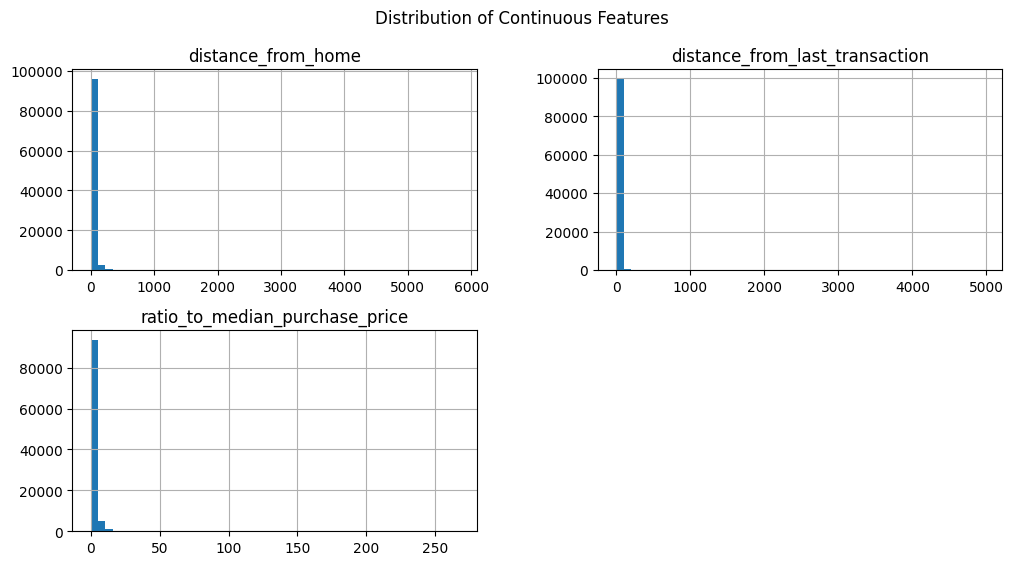

In [9]:
# Histograms for continuous variables
cont_cols = ["distance_from_home", 
             "distance_from_last_transaction", 
             "ratio_to_median_purchase_price"] # list of continuous variable columns

df[cont_cols].hist(bins=50, figsize=(12,6)) # plot histograms for continuous columns 
plt.suptitle("Distribution of Continuous Features") # add a title
plt.show() # display the plots

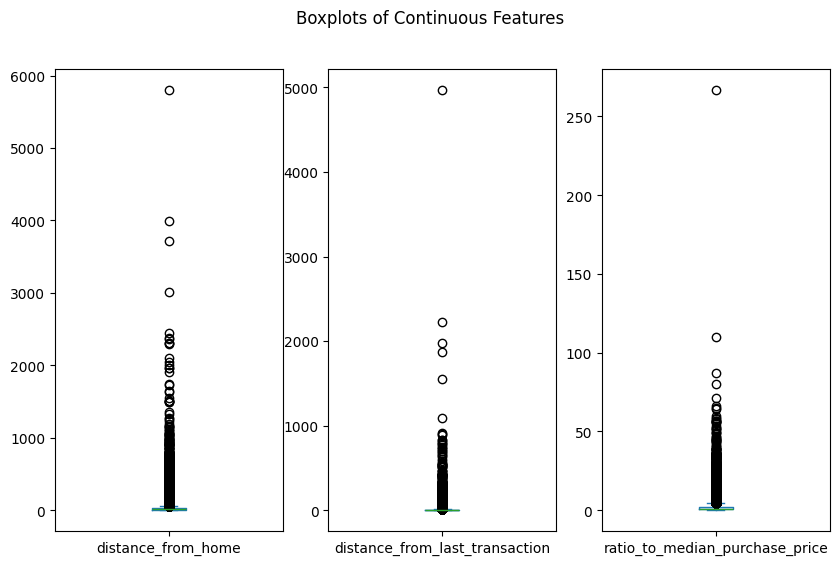

In [10]:
# Boxplots for continuous variables to check for outliers
df[cont_cols].plot(kind='box', subplots=True, layout=(1,3), figsize=(10,6)) # plot boxplots for continuous columns
plt.suptitle("Boxplots of Continuous Features") # add a title
plt.show() # display the plots

In [11]:
# IQR method to identify outliers
for col in cont_cols:
    Q1 = df[col].quantile(0.25) # first quartile
    Q3 = df[col].quantile(0.75) # third quartile
    IQR = Q3 - Q1 # interquartile range
    lower_bound = Q1 - 1.5 * IQR # lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR # upper bound for outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)] # identify outliers
    print(f"{col:35s}: {len(outliers)} outliers (IQR method)") # formatted print of number of outliers

distance_from_home                 : 10397 outliers (IQR method)
distance_from_last_transaction     : 12469 outliers (IQR method)
ratio_to_median_purchase_price     : 8464 outliers (IQR method)


---
# Section 6: Binary Feature Checks and Adjustments
**Goal:**

Confirm that binary variables are correctly encoded as 0/1 and assess their distributions. This ensures data integrity and highlights any imbalance (particularly important for the fraud label).

**Approach:**
- Used .value_counts() to check the frequency of 0s and 1s in each binary feature.
- Created simple bar charts for quick visual confirmation using Matplotlib, chosen because it is lightweight, fast, and effective for categorical comparisons.
- Converted binary variables from float to integer (0/1) where required to improve clarity and memory efficiency for analysis and modelling.

**Results:**
- repeat_retailer is mostly 1 (repeat customers are common).
- used_chip and used_pin_number have more 0 values, indicating many transactions do not use chip or PIN.
- online_order shows a majority of transactions are online.
- fraud is imbalanced with approximately 8.7% positive cases and 91.3% negatives.
- Binary features were successfully converted from float to integer (0/1).

**Insights:**
- Fraud is the only strongly imbalanced feature, which is expected since fraudulent transactions are naturally less frequent. However, this imbalance must be addressed or monitored during modelling.
- Other binary features look realistic and provide meaningful signals (for example, online orders may be associated with higher risk).




repeat_retailer value counts:
repeat_retailer
1.0    0.881
0.0    0.119
Name: proportion, dtype: float64

used_chip value counts:
used_chip
0.0    0.651
1.0    0.349
Name: proportion, dtype: float64

used_pin_number value counts:
used_pin_number
0.0    0.899
1.0    0.101
Name: proportion, dtype: float64

online_order value counts:
online_order
1.0    0.651
0.0    0.349
Name: proportion, dtype: float64

fraud value counts:
fraud
0.0    0.913
1.0    0.087
Name: proportion, dtype: float64


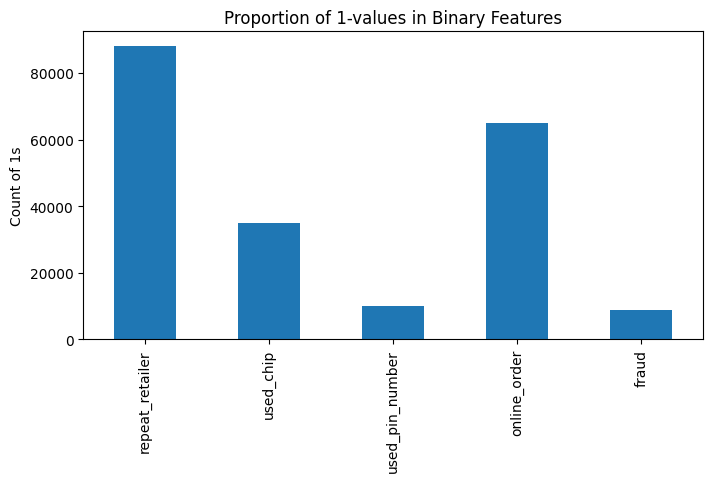

In [12]:
# Binary feature checks
binary_cols = ["repeat_retailer", # list of binary variable columns
               "used_chip", 
               "used_pin_number", 
               "online_order", 
               "fraud"]

# Display value counts for binary columns
for col in binary_cols: # iterate over binary columns
    print(f"\n{col} value counts:") # print column name before value counts for clarity
    print(df[col].value_counts(normalize=True).round(3)) # display value counts for binary columns

# Quick bar plots (Matplotlib) 

df[binary_cols].astype(int).sum().plot(kind="bar", figsize=(8,4)) # bar plot of sum of 1s in binary columns
plt.title("Proportion of 1-values in Binary Features") # add title
plt.ylabel("Count of 1s") # add y-axis label
plt.show() #

**Binary Data Types Adjustment**

In this next step I convert binary features from float to integer (0/1). 

In [13]:
# Covert Binary columns to integer type if not already
binary_cols = ["repeat_retailer",
                "used_chip",
                 "used_pin_number", 
                 "online_order", 
                 "fraud"] # list of binary variable columns
df[binary_cols] = df[binary_cols].astype(int) # convert binary columns to integer type
df[binary_cols].dtypes # display data types of binary columns to confirm conversion

repeat_retailer    int32
used_chip          int32
used_pin_number    int32
online_order       int32
fraud              int32
dtype: object

---
# Section 7: Correlation Analysis

Heatmap to explore relationships between variables and see how strongly they correlate with the target fraud. This helps identify redundancy between features and provides an early indication of predictive signal.

Seaborn’s heatmap was used to visualise correlations between continuous features because it provides a clear, colour-coded summary of relationships. This helps identify which variables may contribute meaningfully to fraud prediction.

**Results:**
- Most features show very low correlation with each other, so multicollinearity is not a concern.
- Correlation with the target fraud is modest:
- ratio_to_median_purchase_price has the strongest positive correlation (0.45).
- distance_from_home (0.18) and online_order (0.19) show weaker positive correlations.
- distance_from_last_transaction is close to 0.09.
- used_chip (–0.06) and used_pin_number (–0.10) show weak negative correlations.
- repeat_retailer is not correlated with fraud.

**Insights:**
- None of the features strongly predict fraud on their own, which is expected in fraud datasets where non-linear patterns matter more than linear correlations.
- The modest correlations suggest all features may still carry useful signal for modelling.
- Skewed continuous features (distance_from_home, distance_from_last_transaction, ratio_to_median_purchase_price) will likely benefit from log transformations in Feature Engineering.

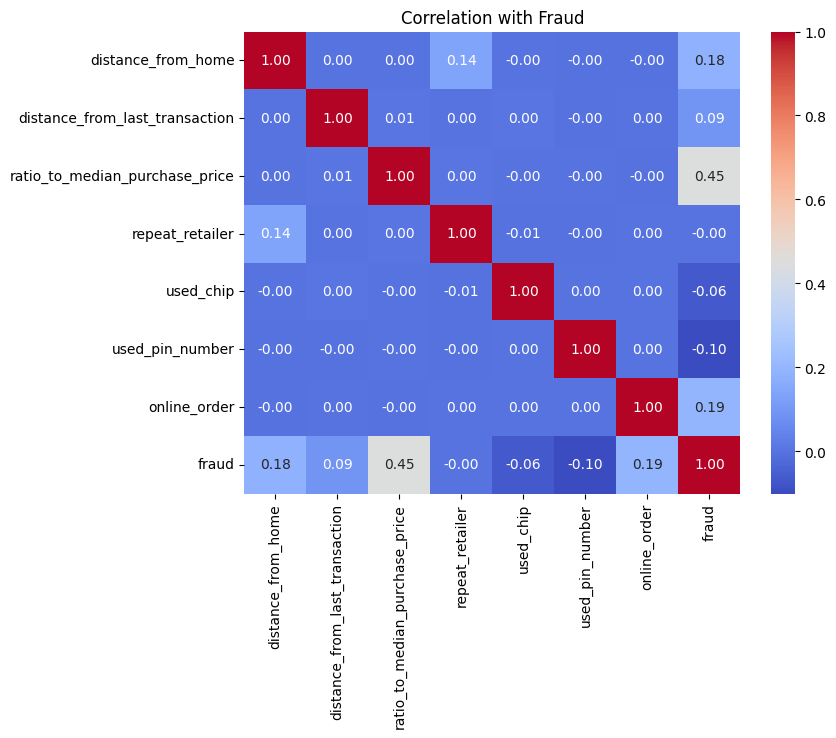

In [14]:
# Correlation Heatmap with Seaborn

corr = df.corr() # calculate the correlation matrix

plt.figure(figsize=(8,6)) # set figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True) # plot the heatmap with annotations
plt.title("Correlation with Fraud") # add a title
plt.show() # display the plott.show() # display the plot

---
# Section 8: Feature Engineering
**Goal**
- Create new variables and transformations to capture fraud patterns that are not easily visible in the raw features. This step improves model performance and interpretability.

**Approach:**
- Applied log transformations to reduce skew in continuous variables.
- Grouped continuous variables into bins (e.g., quintiles) for easier pattern comparison during analysis.
- Engineered interaction features to capture combined effects (e.g., online_order × high distance_from_home, or combinations of binary indicators such as online_order and used_chip).

These transformations were applied alongside the cleaned dataset, so both the raw and engineered versions can be compared during modelling. The engineered variables are saved as additional columns in the processed dataset, which will be used for Modelling, EDA, and Power BI stages.

**Outputs**
- The following new columns were created and verified as part of feature engineering:
    - Log-transformed continuous variables
    - log_distance_from_home
    - log_distance_from_last_transaction
    - log_ratio_to_median_purchase_price
- Binned variables (five equal-frequency bins)
    - log_distance_from_home_bin
    - log_purchase_price_bin
    - log_distance_from_last_transaction_bin
- Interaction and cross-features
    - online_high_distance (flag where the transaction was online and occurred farther than the customer’s median distance from home)
    - online_chip_category, descriptive labels for combinations of online_order, used_chip or no_chip (e.g. e.g., offline_no_chip, offline_with_chip, online_no_chip, online_with_chip)
    - online_and_chip (numeric flag, where both online and chip used).


In [19]:
# Feature Engineering for Modeling and EDA Notebooks

# Log transform the skewed continuous variables to reduce skewness
df["log_distance_from_home"] = np.log1p(df["distance_from_home"]) # log transform distance_from_home
df["log_distance_from_last_transaction"] = np.log1p(df["distance_from_last_transaction"]) # log transform distance_from_last_transaction
df["log_ratio_to_median_purchase_price"] = np.log1p(df["ratio_to_median_purchase_price"]) # log transform ratio_to_median_purchase_price

# Binning continuous variables into quintiles (5 equal-frequency bins)
df["log_distance_from_home_bin"] = pd.qcut(df["log_distance_from_home"], 5, labels=False)
df["log_purchase_price_bin"] = pd.qcut(df["log_ratio_to_median_purchase_price"], 5, labels=False)
df["log_distance_from_last_transaction_bin"] = pd.qcut(df["log_distance_from_last_transaction"], 5, labels=False)

# Interaction features: Combine binary features for analysis

# Online and distance from home interaction
df["online_high_distance"] = df["online_order"] * (df["distance_from_home"] > df["distance_from_home"].median()).astype(int) # interaction of online_order and high distance from home (greater than median)

# Cross-feature: Combine online_order and used_chip with descriptive labels (for EDA and Power BI)
df["online_chip_category"] = (
    df["online_order"].astype(str) + "_" + df["used_chip"].astype(str) # concatenate online_order and used_chip as strings with underscore
).map({
    "0_0": "offline_no_chip", # descriptive labels for combinations
    "0_1": "offline_with_chip", # descriptive labels for combinations
    "1_0": "online_no_chip", # descriptive labels for combinations
    "1_1": "online_with_chip" # descriptive labels for combinations
})

# Numeric interaction flag: 1 = both online AND chip used (for modeling)
df["online_and_chip"] = (df["online_order"] & df["used_chip"]).astype(int) # interaction of online_order and used_chip as numeric flag

# Check the new cross_feature columns to confirm they were added correctly
print("\nCross feature category distribution:") # adds text to the output before the new feature columns for clarity
print (df["online_chip_category"].value_counts()) # display value counts for the new categorical feature
print("\nFraud rates by Cross Category:") # adds text to the output before the fraud rates by new feature for clarity
print (df.groupby("online_chip_category")["fraud"].agg(["mean", "count", "sum"])) # display fraud rates by the new categorical feature
df[["online_order", "used_chip", "online_chip_category", "online_and_chip", "fraud"]].head() # display the first 5 rows of the new feature columns


Cross feature category distribution:
online_chip_category
online_no_chip       42405
offline_no_chip      22738
online_with_chip     22720
offline_with_chip    12137
Name: count, dtype: int64

Fraud rates by Cross Category:
                          mean  count   sum
online_chip_category                       
offline_no_chip       0.017284  22738   393
offline_with_chip     0.005520  12137    67
online_no_chip        0.144818  42405  6141
online_with_chip      0.094146  22720  2139


,online_order,used_chip,online_chip_category,online_and_chip,fraud
0,1,0,online_no_chip,0,0
1,1,1,online_with_chip,1,0
2,0,1,offline_with_chip,0,0
3,1,0,online_no_chip,0,0
4,0,0,offline_no_chip,0,0
